In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import sys
sys.path.append(os.path.join(os.getcwd(), "functions"))
import helper_functions as hfn
import plotting_functions as plotfn
import multireg_functions as mregfn

# define data and save paths

In [2]:
path = os.getcwd()
alldatapath = os.path.join(path,'data')
datapath = os.path.join(alldatapath,'clean')

savepath = os.path.join(path, 'multireg')
hfn.dir_check(savepath)

savepath_lin= os.path.join(savepath, 'lin_scale')
hfn.dir_check(savepath_lin)

savepath_log= os.path.join(savepath, 'log_scale')
hfn.dir_check(savepath_log)

savepath_lin_fig, savepath_lin_df, savepath_lin_csv = hfn.create_subfolders(savepath_lin)
savepath_log_fig, savepath_log_df, savepath_log_csv = hfn.create_subfolders(savepath_log)

In [3]:
list_areas = ['LGd','LP','LD','AM','ORB','ACA','AUD','PTLp','TEa','MOs','CLA','VISp','VISpm','VISam','VISl','VISal','RSPv','RSPd','RSPagl']

# import data

In [4]:
df_starter = pd.read_hdf(os.path.join(datapath, 'df_starters.h5'))

In [5]:
df_starter.head()

,name,target area,strain,group,starter,Ratio of V1orPM from all startes,PM,V1,RSP,AM,input
0,ERAD25_1a,V1,GLT,1,3,1.0,0,3,0,0,2451
1,ERAD25_1b,PM,GLT,2,8,1.0,6,2,0,0,8418
2,BRAC2704_6c,V1,RETRO,10,2,1.0,1,1,0,0,2729
3,BRAC2704_6d,V1,RETRO,10,13,1.0,2,11,0,0,7486
4,ERAD26_3d,PM,GLT,3,17,1.0,5,12,0,0,8735


In [6]:
df_starter=df_starter.sort_values(by = 'name')

In [7]:
areas, areas_with_pre, df_raw, df_all, df_v1, df_pm = hfn.import_main_dataset(datapath)

In [8]:
df_all= df_all.sort_values(by ='name')

In [9]:
# log10 transformed datasets
df_log_all = hfn.make_log_df_full(df_all, areas)

In [10]:
df_all = df_all.rename(columns={'target area': 'target_area', 'V1/PM': 'area_ratio'})
df_log_all = df_log_all.rename(columns={'target area': 'target_area', 'V1/PM': 'area_ratio'})

In [11]:
df_log_all['strain_enc'] = df_log_all.strain.map({'GLT':0, 'RETRO':1, 'RBP':2, 'TLX':3})
df_all['strain_enc'] = df_all.strain.map({'GLT':0, 'RETRO':1, 'RBP':2, 'TLX':3})

In [12]:
df_all['analyze'] = 1
df_log_all['analyze'] = 1

In [13]:
#drop the 2 RETRO cases for starters> 200 (set 'analyze' value to 0)
df_all['analyze'][(df_all['strain'] == 'RETRO') & (df_all['starter']>200)] = 0
df_log_all['analyze'][(df_all['strain'] == 'RETRO') & (df_all['starter']>200)] = 0

/var/folders/n7/dvksxsf55hxbzrrfm5gv88cwmxqfb7/T/ipykernel_33201/3951944679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['analyze'][(df_all['strain'] == 'RETRO') & (df_all['starter']>200)] = 0
/var/folders/n7/dvksxsf55hxbzrrfm5gv88cwmxqfb7/T/ipykernel_33201/3951944679.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_log_all['analyze'][(df_all['strain'] == 'RETRO') & (df_all['starter']>200)] = 0


## normalize V1/PM starter ratio between -1 and 1

In [14]:
df_starter['PM_V1'] = df_starter['PM'] + df_starter['V1']
df_starter['sintargets_frac'] = df_starter['PM_V1'] / df_starter['starter']
df_starter['sPM_frac'] = df_starter['PM'] / df_starter['PM_V1']
df_starter['sV1_frac'] = df_starter['V1'] / df_starter['PM_V1']
df_starter['norm_frac'] = 2 * (df_starter['sV1_frac'] - 0 )/ (1-0) - 1

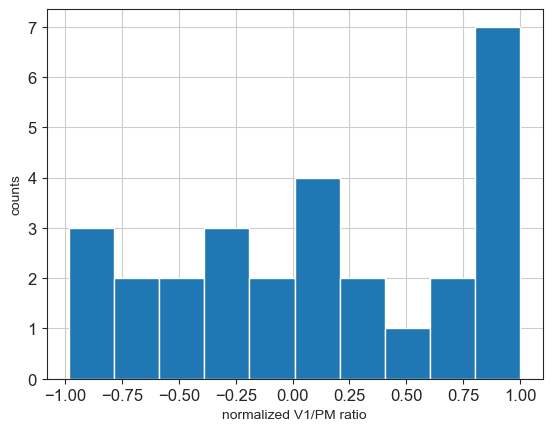

In [15]:
df_starter['norm_frac'].hist(bins = 10)
plt.xlabel('normalized V1/PM ratio')
plt.ylabel('counts')
plt.tick_params(labelsize=12)

In [16]:
df_all = pd.concat([df_all.reset_index(drop = True), df_starter[['name','norm_frac']].reset_index(drop = True)], axis = 1)

In [17]:
df_all= df_all.T.drop_duplicates().T

In [18]:
df_log_all = pd.concat([df_log_all.reset_index(drop = True), df_starter[['name', 'norm_frac']].reset_index(drop = True)], axis = 1)
df_log_all= df_log_all.T.drop_duplicates().T

In [19]:
df_all[df_all['analyze'] == 0]

,name,pre,input,target_area,strain,starter,ratio_target_all,area,keep,PTLp,...,LD,LP,LGd,ORB,ACA,MOs,CLA,strain_enc,analyze,norm_frac
6,ERAA10_4j,14502,13747,PM,RETRO,207,0.932367,PM,1,508,...,709,572,572,94,833,270,201,1,0,0.097826


# Calculate TIP

In [20]:
# calculate TIP (fraction of whole brain input per area)
TIP_list = []
for area in areas:
    df_all['TIP_' + area] = df_all[area]/df_all['input']
    df_log_all['TIP_' + area] = df_log_all[area] - df_log_all['input']
    TIP_list.append('TIP_' + area)

In [21]:
# keep data to analyze and classify by number of starters

df_all_200p = df_all[df_all['starter']>=200]
df_log_all_200p = df_log_all[df_log_all['starter']>=np.log10(200)]
df_all_200m = df_all[df_all['starter']<200]
df_log_all_200m = df_log_all[df_log_all['starter']<np.log10(200)]

In [22]:
di = {'GLT': 'PT', 'RETRO': 'PT', 'TLX' : 'IT', 'RBP': 'mixed'}
df_all['cell_type'] = df_all['strain'].copy()
df_all = df_all.replace({"cell_type": di})

In [23]:
df_all.to_hdf(os.path.join(savepath, 'df_all.h5'), key = 'df_all', mode = 'w')

/var/folders/n7/dvksxsf55hxbzrrfm5gv88cwmxqfb7/T/ipykernel_33201/2845119804.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['name', 'pre', 'input', 'target_area', 'strain', 'starter',
       'ratio_target_all', 'area', 'keep', 'PTLp', 'TEa', 'VIS', 'AUD', 'RSP',
       'Thal', 'Thal_noLGd', 'Dist_ctx', 'VISp', 'VISpm', 'VISl', 'VISam',
       'VISal', 'RSPagl', 'RSPd', 'RSPv', 'AM', 'LD', 'LP', 'LGd', 'ORB',
       'ACA', 'MOs', 'CLA', 'strain_enc', 'analyze', 'norm_frac', 'TIP_PTLp',
       'TIP_TEa', 'TIP_VIS', 'TIP_AUD', 'TIP_RSP', 'TIP_Thal',
       'TIP_Thal_noLGd', 'TIP_Dist_ctx', 'TIP_VISp', 'TIP_VISpm', 'TIP_VISl',
       'TIP_VISam', 'TIP_VISal', 'TIP_RSPagl', 'TIP_RSPd', 'TIP_RSPv',
       'TIP_AM', 'TIP_LD', 'TIP_LP', 'TIP_LGd', 'TIP_ORB', 'TIP_ACA',
       'TIP_MOs', 'TIP_CLA', 'cell_type'],
      dtype='object')]

  df_all.to_h

# plot distributions

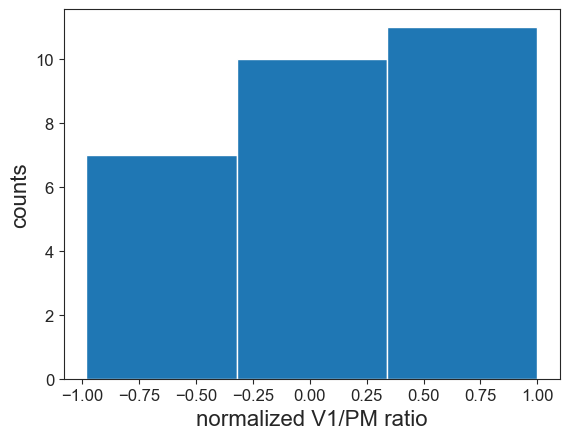

In [24]:
h = plt.hist(df_all['norm_frac'], bins = 3)
plt.xlabel('normalized V1/PM ratio', fontsize = 16)
plt.ylabel('counts', fontsize = 16)
plt.tick_params(labelsize=12)

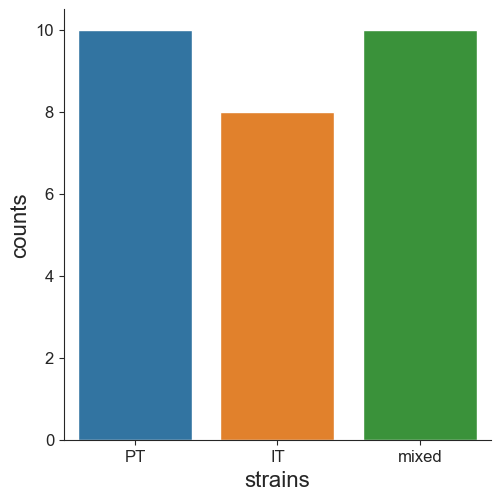

In [25]:
sns.catplot(data = df_all, x = 'cell_type',kind="count")
plt.ylabel('counts', fontsize = 16)
plt.xlabel('strains', fontsize = 16)
plt.tick_params(labelsize=12)

<AxesSubplot: xlabel='norm_frac', ylabel='input'>

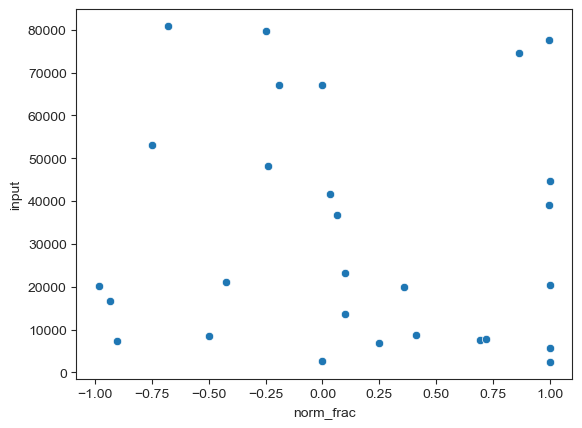

In [26]:
sns.scatterplot(data=df_all, x="norm_frac", y="input")#, hue = 'strain')

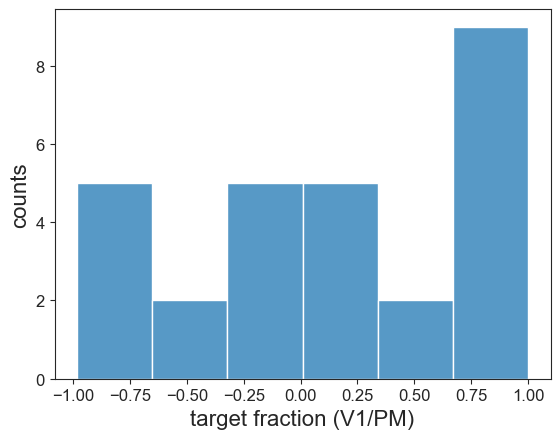

In [27]:
sns.histplot(data = df_all,  x="norm_frac")#, kde=True, bins = 3)

plt.ylabel('counts', fontsize = 16)
plt.xlabel('target fraction (V1/PM)', fontsize = 16)
plt.tick_params(labelsize=12)

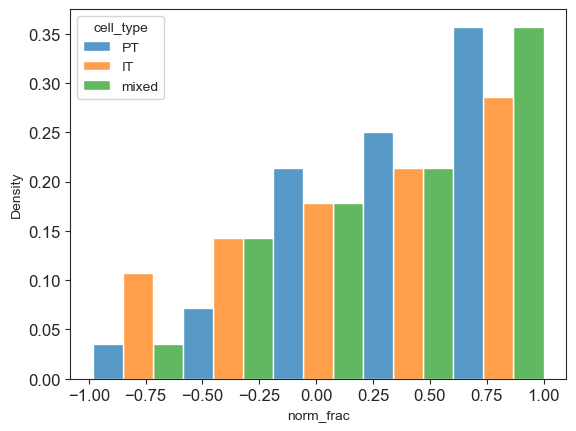

In [28]:
sns.histplot(data = df_all,  x="norm_frac", hue = 'cell_type',  multiple = 'dodge',cumulative=True,stat="density",  bins = 5)
plt.tick_params(labelsize=12)


<AxesSubplot: xlabel='norm_frac', ylabel='Density'>

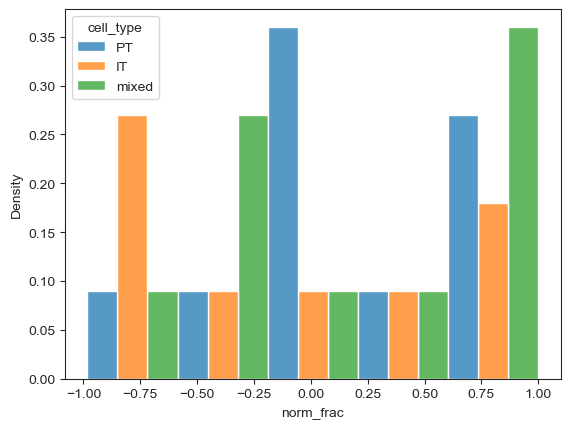

In [29]:
sns.histplot(data = df_all,  x="norm_frac", hue = 'cell_type',  multiple = 'dodge',stat="density", bins = 5)


<AxesSubplot: xlabel='norm_frac', ylabel='starter'>

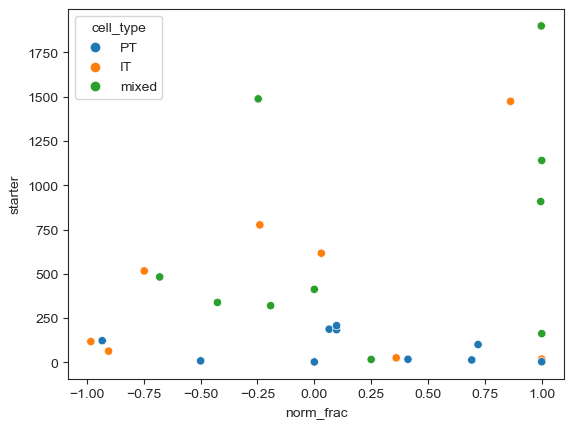

In [30]:
sns.scatterplot(data=df_all, x="norm_frac", y="starter", hue = 'cell_type',)

# **1. Analyze full dataset in linear scale (not separated by #starters)**

In [31]:
df_res_lin_all, df_r2_lin_all = mregfn.run_multireg(df_all, ['starter', 'norm_frac', 'strain_enc'], TIP_list)

df_res_lin_starter, df_r2_lin_starter = mregfn.run_multireg(df_all, ['starter'], TIP_list)

df_res_lin_norms, df_r2_lin_norms = mregfn.run_multireg(df_all, ['norm_frac'], TIP_list)

df_res_lin_gen, df_r2_lin_gen = mregfn.run_multireg(df_all, ['strain_enc'], TIP_list)

df_res_lin_starter_norms, df_r2_lin_starter_norms = mregfn.run_multireg(df_all, ['starter', 'norm_frac'], TIP_list)

df_res_lin_starter_gen, df_r2_lin_starter_gen = mregfn.run_multireg(df_all, ['starter', 'strain_enc'], TIP_list)

df_res_lin_norms_gen, df_r2_lin_norms_gen = mregfn.run_multireg(df_all, ['norm_frac', 'strain_enc'], TIP_list)

In [32]:
list_r2_lin = pd.concat([df_r2_lin_starter['area'], df_r2_lin_starter['r2'], df_r2_lin_norms['r2'], df_r2_lin_gen['r2'], df_r2_lin_norms_gen['r2'], df_r2_lin_starter_norms['r2'], df_r2_lin_starter_gen['r2'], df_r2_lin_all['r2']], axis = 1)
list_r2_lin.columns = ['area', 'starter', 'target_frac', 'genotype', 'target_frac + genotype', 'starter + target_frac', 'starter + genotype', 'starter + target_frac + genotype']
list_r2_lin = list_r2_lin.set_index('area')

list_r2_lin_filt = list_r2_lin[list_r2_lin.index.isin(list_areas)]
list_r2_lin_filt = list_r2_lin_filt.reindex(list_areas)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


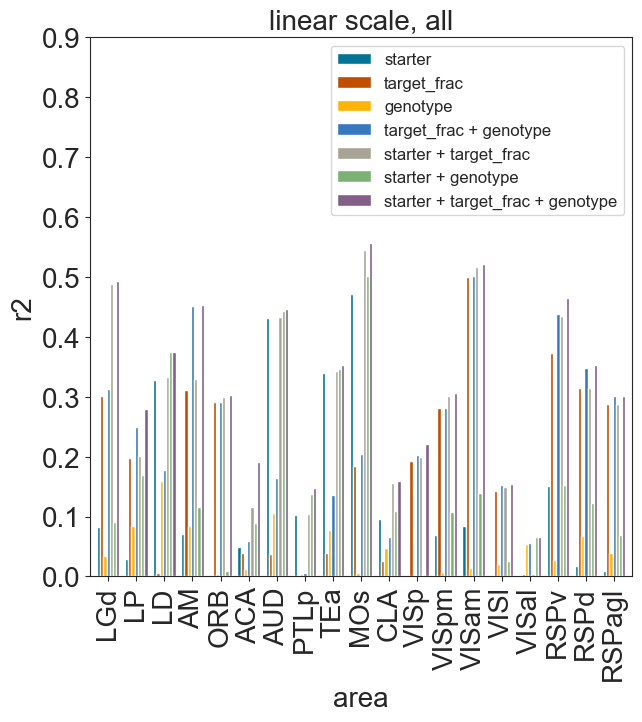

In [33]:
plotfn.plot_multivar(list_r2_lin_filt, 'linear scale, all', 'multivar_tip_all', savepath_lin_fig, 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


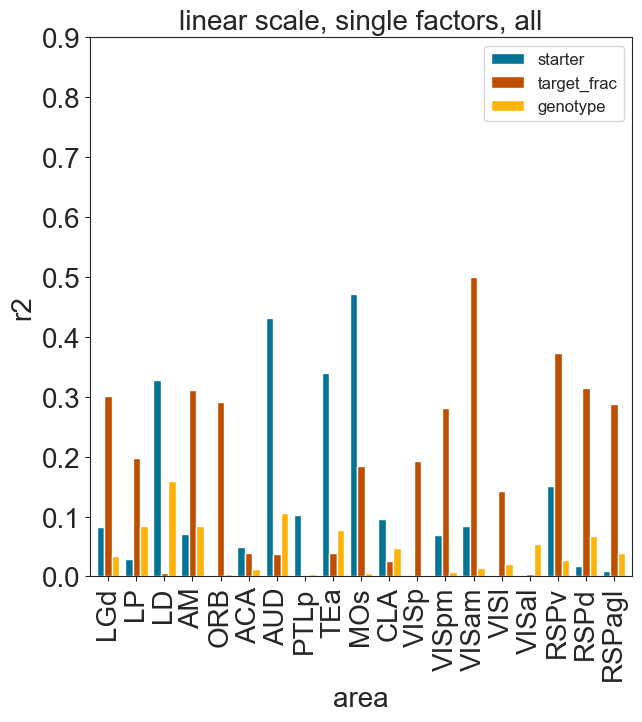

In [34]:
plotfn.plot_multivar(list_r2_lin_filt[['starter', 'target_frac', 'genotype']], 'linear scale, single factors, all', 'multivar_tip_single_factors_allstarters', savepath_lin_fig, 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


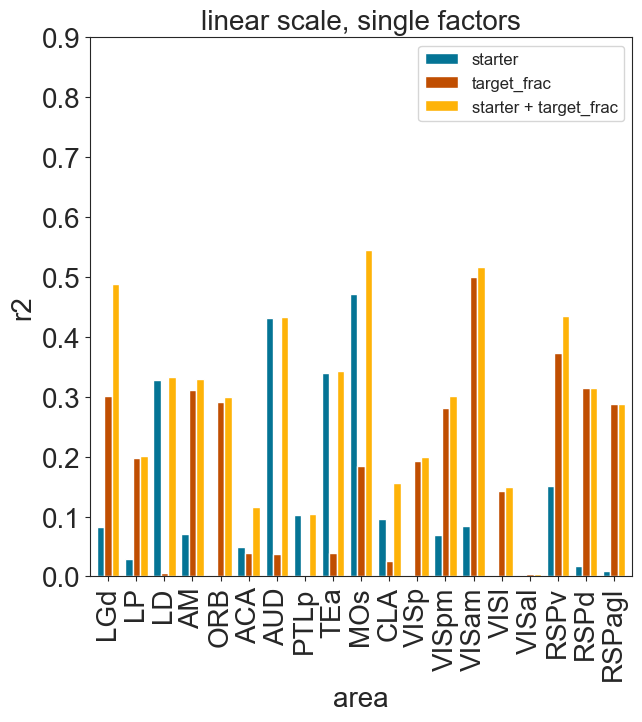

In [35]:
plotfn.plot_multivar(list_r2_lin_filt[['starter', 'target_frac', 'starter + target_frac']], 'linear scale, single factors', 'multivar_tip_st_targ_frac_allstarters', savepath_lin_fig, 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


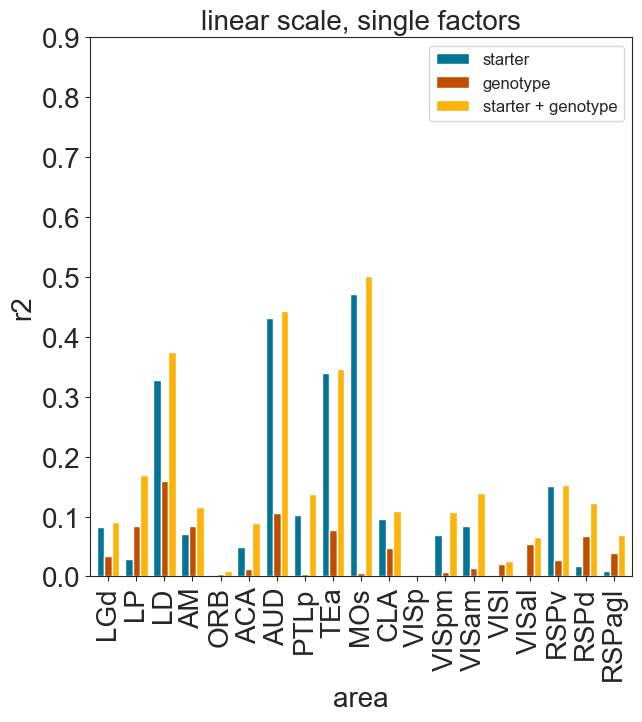

In [36]:
plotfn.plot_multivar(list_r2_lin_filt[['starter', 'genotype', 'starter + genotype']], 'linear scale, single factors', 'multivar_tip_st_gen_allstarters', savepath_lin_fig, 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


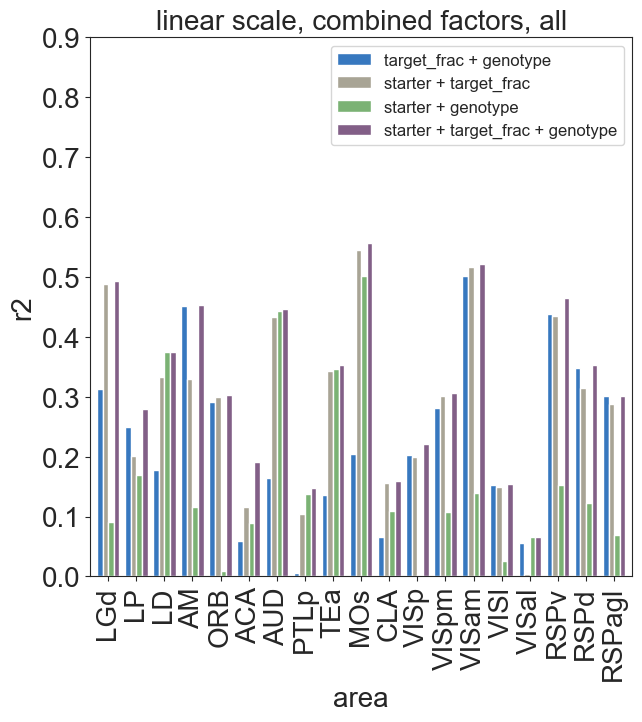

In [37]:
plotfn.plot_multivar(list_r2_lin_filt[['target_frac + genotype', 'starter + target_frac', 'starter + genotype', 'starter + target_frac + genotype']], 'linear scale, combined factors, all', 'multivar_tip_comb_factors_allstarters', savepath_lin_fig, 2)

# **2.Analyze dataset in linear scale for #starters > 200**

In [38]:
df_res_lin_200p_all, df_r2_lin_200p_all = mregfn.run_multireg(df_all_200p, ['starter', 'norm_frac', 'strain_enc'], TIP_list)

df_res_lin_200p_starter, df_r2_lin_200p_starter = mregfn.run_multireg(df_all_200p, ['starter'], TIP_list)

df_res_lin_200p_norms, df_r2_lin_200p_norms = mregfn.run_multireg(df_all_200p, ['norm_frac'], TIP_list)

df_res_lin_200p_gen, df_r2_lin_200p_gen = mregfn.run_multireg(df_all_200p, ['strain_enc'], TIP_list)

df_res_lin_200p_starter_norms, df_r2_lin_200p_starter_norms = mregfn.run_multireg(df_all_200p, ['starter', 'norm_frac'], TIP_list)

df_res_lin_200p_starter_gen, df_r2_lin_200p_starter_gen = mregfn.run_multireg(df_all_200p, ['starter', 'strain_enc'], TIP_list)

df_res_lin_200p_norms_gen, df_r2_lin_200p_norms_gen = mregfn.run_multireg(df_all_200p, ['norm_frac', 'strain_enc'], TIP_list)

/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: 

/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: 

In [39]:
list_r2_lin_200p = pd.concat([df_r2_lin_200p_starter['area'], df_r2_lin_200p_starter['r2'], df_r2_lin_200p_norms['r2'], df_r2_lin_200p_gen['r2'], df_r2_lin_200p_norms_gen['r2'], df_r2_lin_200p_starter_norms['r2'], df_r2_lin_200p_starter_gen['r2'], df_r2_lin_200p_all['r2']], axis = 1)
list_r2_lin_200p.columns = ['area', 'starter', 'target_frac', 'genotype', 'target_frac + genotype', 'starter + target_frac', 'starter + genotype', 'starter + target_frac + genotype']
list_r2_lin_200p = list_r2_lin_200p.set_index('area')

list_r2_lin_200p_filt = list_r2_lin_200p[list_r2_lin_200p.index.isin(list_areas)]
list_r2_lin_200p_filt = list_r2_lin_200p_filt.reindex(list_areas)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


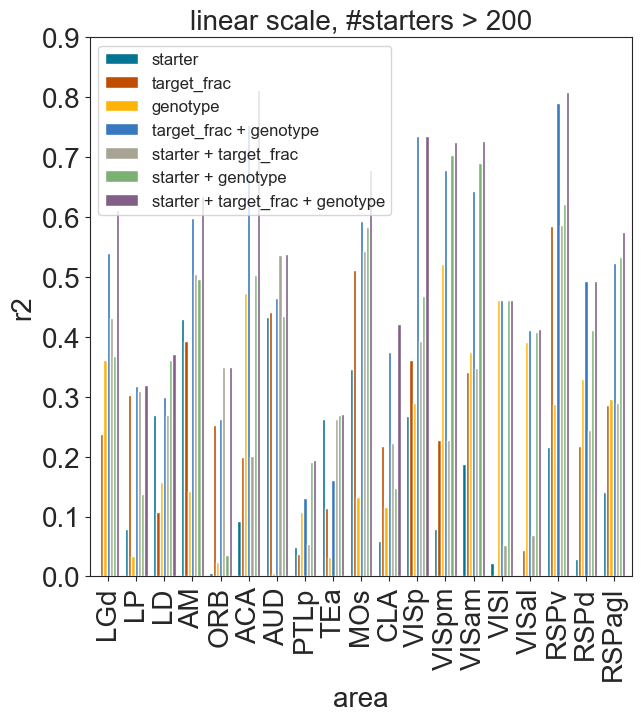

In [40]:
plotfn.plot_multivar(list_r2_lin_200p_filt, 'linear scale, #starters > 200', 'multivar_tip_starters200p', savepath_lin_fig, 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


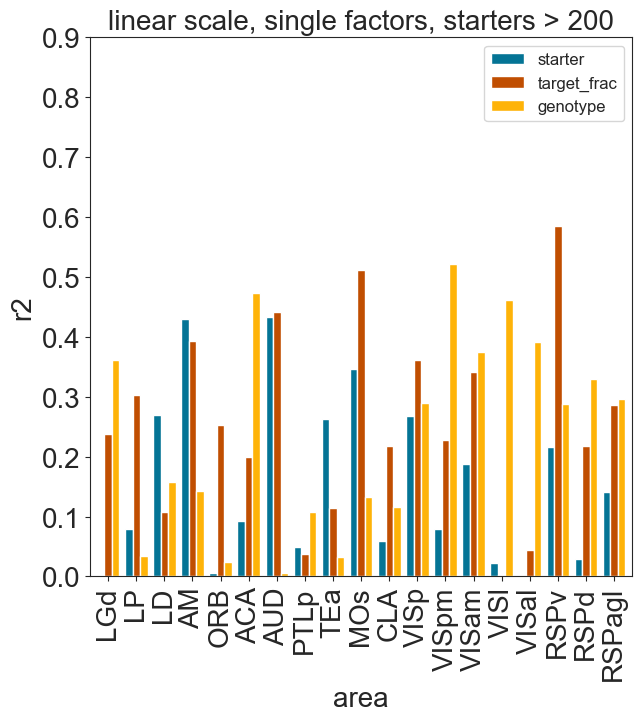

In [41]:
plotfn.plot_multivar(list_r2_lin_200p_filt[['starter', 'target_frac', 'genotype']], 'linear scale, single factors, starters > 200', 'multivar_tip_single_factors_starters_200p', savepath_lin_fig, 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


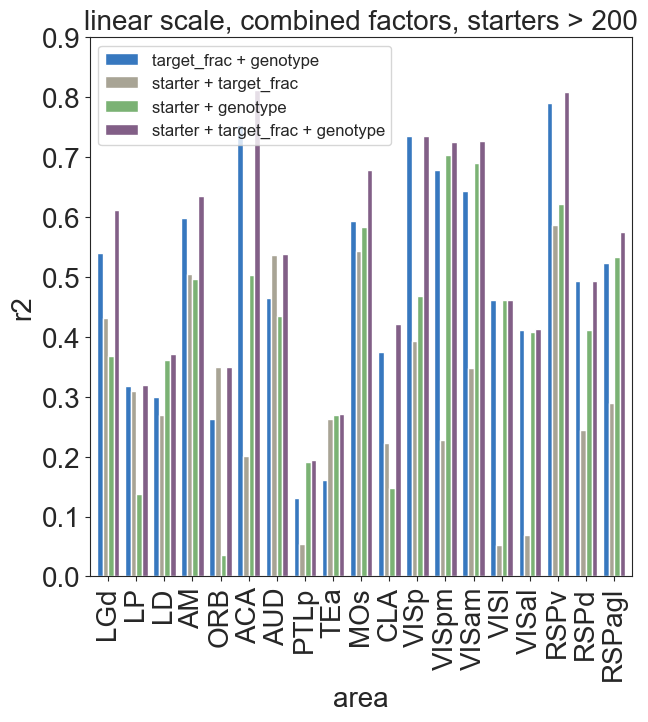

In [42]:
plotfn.plot_multivar(list_r2_lin_200p_filt[['target_frac + genotype', 'starter + target_frac', 'starter + genotype', 'starter + target_frac + genotype']], 'linear scale, combined factors, starters > 200', 'multivar_tip_comb_factors_starters_200p', savepath_lin_fig, 2)

# **3.Analyze dataset in linear scale for #starters < 200**

In [43]:
df_res_lin_200m_all, df_r2_lin_200m_all = mregfn.run_multireg(df_all_200m, ['starter', 'norm_frac', 'strain_enc'], TIP_list)

df_res_lin_200m_starter, df_r2_lin_200m_starter = mregfn.run_multireg(df_all_200m, ['starter'], TIP_list)

df_res_lin_200m_norms, df_r2_lin_200m_norms = mregfn.run_multireg(df_all_200m, ['norm_frac'], TIP_list)

df_res_lin_200m_gen, df_r2_lin_200m_gen = mregfn.run_multireg(df_all_200m, ['strain_enc'], TIP_list)

df_res_lin_200m_starter_norms, df_r2_lin_200m_starter_norms = mregfn.run_multireg(df_all_200m, ['starter', 'norm_frac'], TIP_list)

df_res_lin_200m_starter_gen, df_r2_lin_200m_starter_gen = mregfn.run_multireg(df_all_200m, ['starter', 'strain_enc'], TIP_list)

df_res_lin_200m_norms_gen, df_r2_lin_200m_norms_gen = mregfn.run_multireg(df_all_200m, ['norm_frac', 'strain_enc'], TIP_list)

/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: 

/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: 

In [44]:
list_r2_lin_200m = pd.concat([df_r2_lin_200m_starter['area'], df_r2_lin_200m_starter['r2'], df_r2_lin_200m_norms['r2'], df_r2_lin_200m_gen['r2'], df_r2_lin_200m_norms_gen['r2'], df_r2_lin_200m_starter_norms['r2'], df_r2_lin_200m_starter_gen['r2'], df_r2_lin_200m_all['r2']], axis = 1)
list_r2_lin_200m.columns = ['area', 'starter', 'target_frac', 'genotype', 'target_frac + genotype', 'starter + target_frac', 'starter + genotype', 'starter + target_frac + genotype']
list_r2_lin_200m = list_r2_lin_200m.set_index('area')

list_r2_lin_200m_filt = list_r2_lin_200m[list_r2_lin_200m.index.isin(list_areas)]
list_r2_lin_200m_filt = list_r2_lin_200m_filt.reindex(list_areas)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


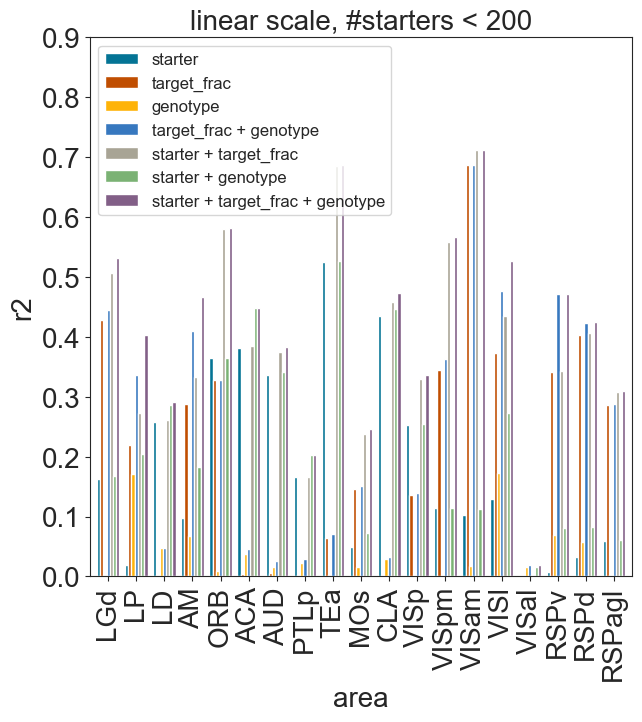

In [45]:
plotfn.plot_multivar(list_r2_lin_200m_filt, 'linear scale, #starters < 200', 'multivar_tip_starters200m', savepath_lin_fig, 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


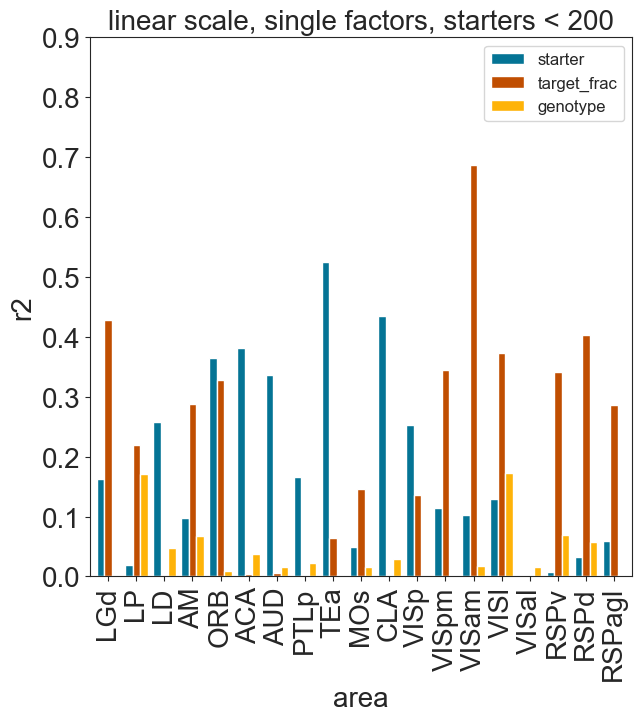

In [46]:
plotfn.plot_multivar(list_r2_lin_200m_filt[['starter', 'target_frac', 'genotype']], 'linear scale, single factors, starters < 200', 'multivar_tip_single_factors_starters_200m', savepath_lin_fig, 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


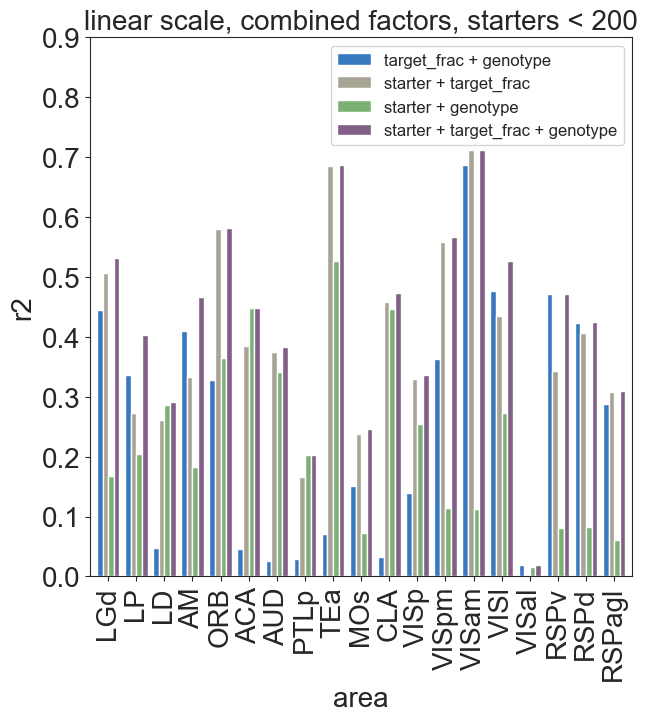

In [47]:
plotfn.plot_multivar(list_r2_lin_200m_filt[['target_frac + genotype', 'starter + target_frac', 'starter + genotype', 'starter + target_frac + genotype']], 'linear scale, combined factors, starters < 200', 'multivar_tip_comb_factors_starters_200m', savepath_lin_fig, 2)

# **4.Analyze full dataset in log scale (not separated by #starters)**

In [48]:
df_res_log_all, df_r2_log_all = mregfn.run_multireg(df_log_all, ['starter', 'norm_frac', 'strain_enc'], TIP_list)

df_res_log_starter, df_r2_log_starter = mregfn.run_multireg(df_log_all, ['starter'], TIP_list)

df_res_log_norms, df_r2_log_norms = mregfn.run_multireg(df_log_all, ['norm_frac'], TIP_list)

df_res_log_gen, df_r2_log_gen = mregfn.run_multireg(df_log_all, ['strain_enc'], TIP_list)

df_res_log_starter_norms, df_r2_log_starter_norms = mregfn.run_multireg(df_log_all, ['starter', 'norm_frac'], TIP_list)

df_res_log_starter_gen, df_r2_log_starter_gen = mregfn.run_multireg(df_log_all, ['starter', 'strain_enc'], TIP_list)

df_res_log_norms_gen, df_r2_log_norms_gen = mregfn.run_multireg(df_log_all, ['norm_frac', 'strain_enc'], TIP_list)

In [49]:
list_r2_log = pd.concat([df_r2_log_starter['area'], df_r2_log_starter['r2'], df_r2_log_norms['r2'], df_r2_log_gen['r2'], df_r2_log_norms_gen['r2'], df_r2_log_starter_norms['r2'], df_r2_log_starter_gen['r2'], df_r2_log_all['r2']], axis = 1)
list_r2_log.columns = ['area', 'starter', 'target_frac', 'genotype', 'target_frac + genotype', 'starter + target_frac', 'starter + genotype', 'starter + target_frac + genotype']
list_r2_log = list_r2_log.set_index('area')

list_r2_log_filt = list_r2_log[list_r2_lin.index.isin(list_areas)]
list_r2_log_filt = list_r2_log_filt.reindex(list_areas)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


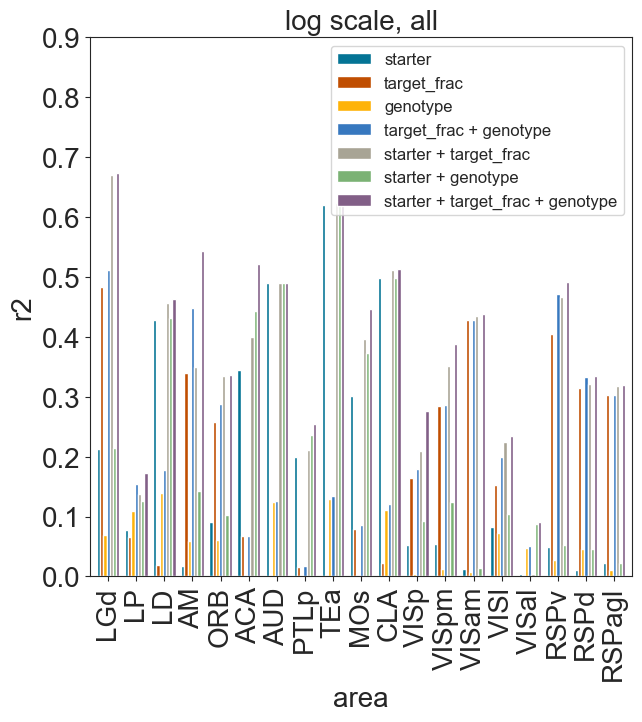

In [50]:
plotfn.plot_multivar(list_r2_log_filt, 'log scale, all', 'multivar_tip_log_all', savepath_log_fig, 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


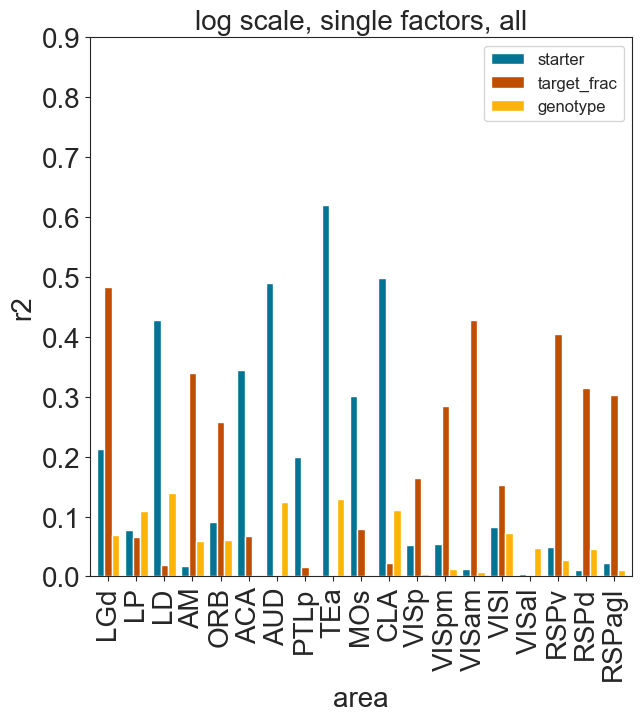

In [51]:
plotfn.plot_multivar(list_r2_log_filt[['starter', 'target_frac', 'genotype']], 'log scale, single factors, all', 'multivar_tip_single_factors_log_allstarters', savepath_log_fig, 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


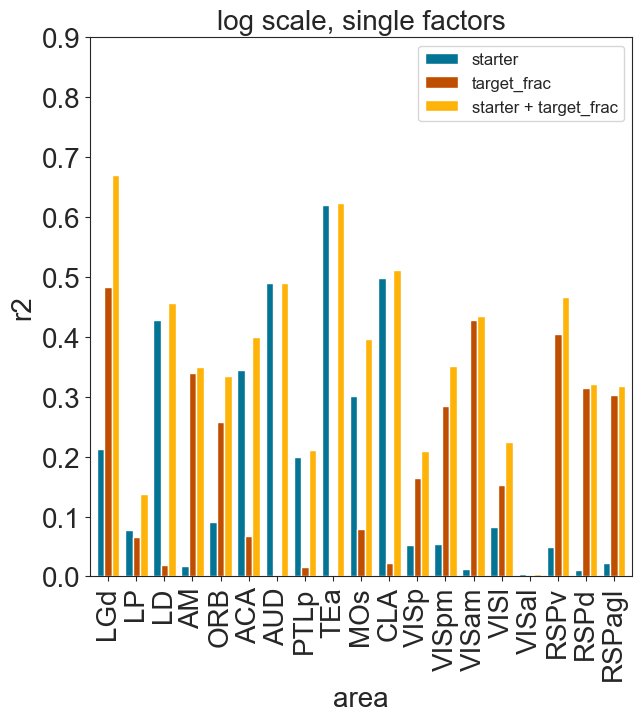

In [52]:
plotfn.plot_multivar(list_r2_log_filt[['starter', 'target_frac', 'starter + target_frac']], 'log scale, single factors', 'multivar_tip_st_target_frac_log_allstarters', savepath_log_fig, 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


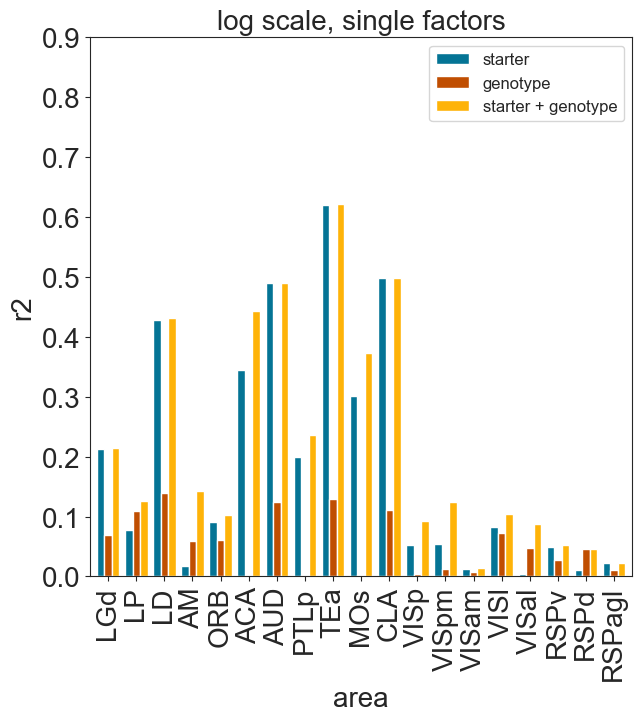

In [53]:
plotfn.plot_multivar(list_r2_log_filt[['starter', 'genotype', 'starter + genotype']], 'log scale, single factors', 'multivar_tip_st_gen_log_allstarters', savepath_log_fig, 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


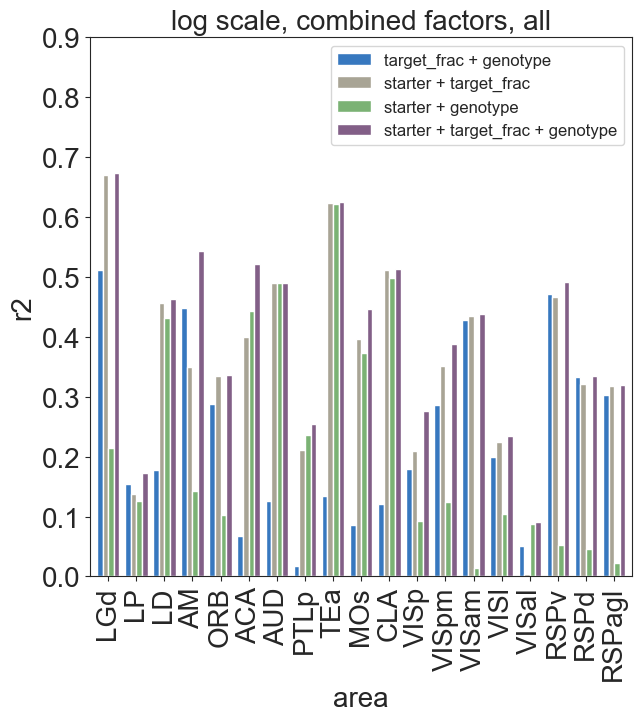

In [54]:
plotfn.plot_multivar(list_r2_log_filt[['target_frac + genotype', 'starter + target_frac', 'starter + genotype', 'starter + target_frac + genotype']], 'log scale, combined factors, all', 'multivar_tip_comb_factors_log_allstarters', savepath_log_fig, 2)

# **5.Analyze dataset in log scale for #starters < 200**

In [55]:
df_res_log_200m_all, df_r2_log_200m_all = mregfn.run_multireg(df_log_all_200m, ['starter', 'norm_frac', 'strain_enc'], TIP_list)

df_res_log_200m_starter, df_r2_log_200m_starter = mregfn.run_multireg(df_log_all_200m, ['starter'], TIP_list)

df_res_log_200m_norms, df_r2_log_200m_norms = mregfn.run_multireg(df_log_all_200m, ['norm_frac'], TIP_list)

df_res_log_200m_gen, df_r2_log_200m_gen = mregfn.run_multireg(df_log_all_200m, ['strain_enc'], TIP_list)

df_res_log_200m_starter_norms, df_r2_log_200m_starter_norms = mregfn.run_multireg(df_log_all_200m, ['starter', 'norm_frac'], TIP_list)

df_res_log_200m_starter_gen, df_r2_log_200m_starter_gen = mregfn.run_multireg(df_log_all_200m, ['starter', 'strain_enc'], TIP_list)

df_res_log_200m_norms_gen, df_r2_log_200m_norms_gen = mregfn.run_multireg(df_log_all_200m, ['norm_frac', 'strain_enc'], TIP_list)

/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: 

/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: 

In [56]:
list_r2_log_200m = pd.concat([df_r2_log_200m_starter['area'], df_r2_log_200m_starter['r2'], df_r2_log_200m_norms['r2'], df_r2_log_200m_gen['r2'], df_r2_log_200m_norms_gen['r2'], df_r2_log_200m_starter_norms['r2'], df_r2_log_200m_starter_gen['r2'], df_r2_log_200m_all['r2']], axis = 1)
list_r2_log_200m.columns = ['area', 'starter', 'target_frac', 'genotype', 'target_frac + genotype', 'starter + target_frac', 'starter + genotype', 'starter + target_frac + genotype']
list_r2_log_200m = list_r2_log_200m.set_index('area')

list_r2_log_200m_filt = list_r2_log_200m[list_r2_log_200m.index.isin(list_areas)]
list_r2_log_200m_filt = list_r2_log_200m_filt.reindex(list_areas)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


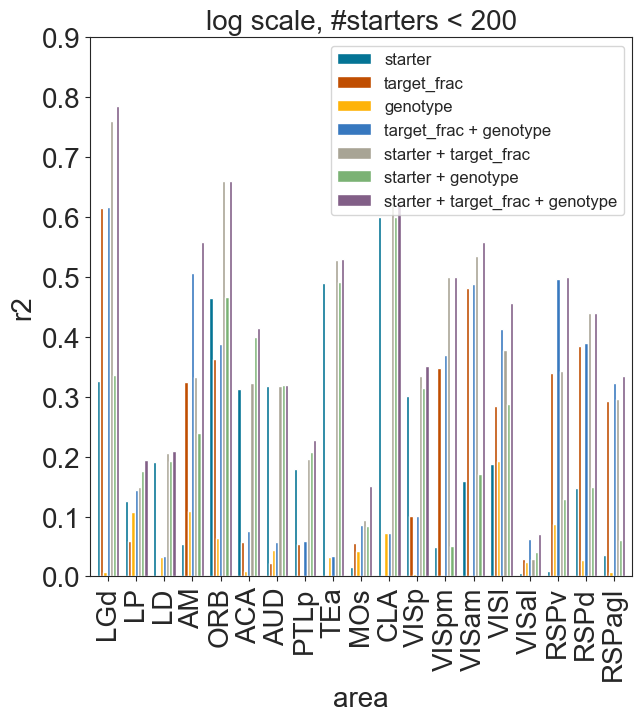

In [57]:
plotfn.plot_multivar(list_r2_log_200m_filt, 'log scale, #starters < 200', 'multivar_tip_log_starters200m', savepath_log_fig, 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


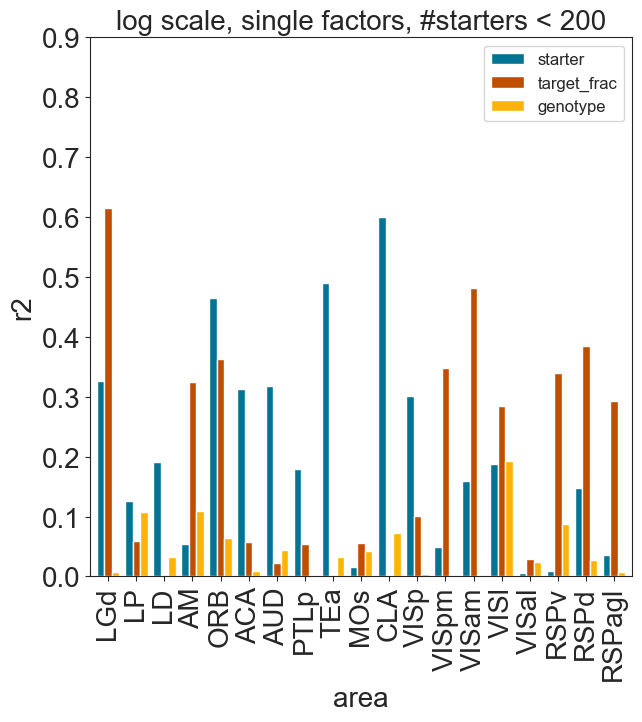

In [58]:
plotfn.plot_multivar(list_r2_log_200m_filt[['starter', 'target_frac', 'genotype']], 'log scale, single factors, #starters < 200', 'multivar_tip_single_factors_log_starters200m', savepath_log_fig, 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


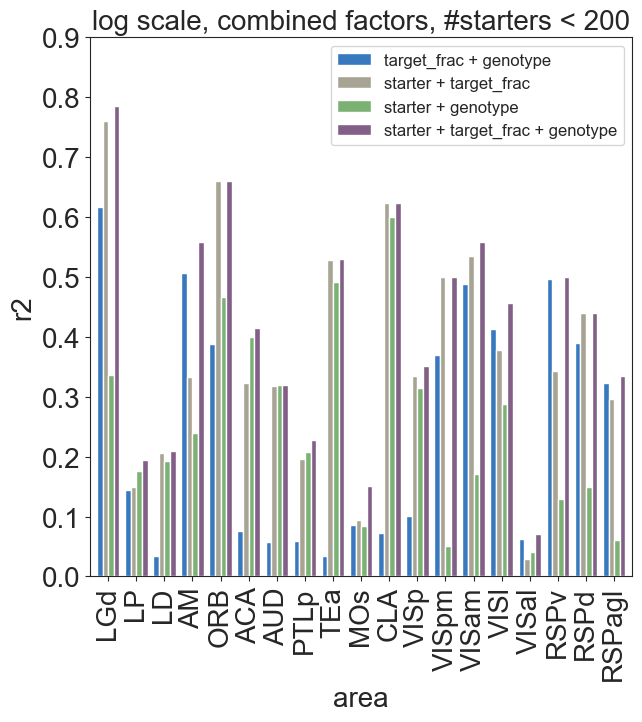

In [59]:
plotfn.plot_multivar(list_r2_log_200m_filt[['target_frac + genotype', 'starter + target_frac', 'starter + genotype', 'starter + target_frac + genotype']], 'log scale, combined factors, #starters < 200', 'multivar_tip_comb_factors_log_starters200m', savepath_log_fig, 2)

# **6.Analyze dataset in log scale for #starters >200**

In [60]:
df_res_log_200p_all, df_r2_log_200p_all = mregfn.run_multireg(df_log_all_200p, ['starter', 'norm_frac', 'strain_enc'], TIP_list)

df_res_log_200p_starter, df_r2_log_200p_starter = mregfn.run_multireg(df_log_all_200p, ['starter'], TIP_list)

df_res_log_200p_norms, df_r2_log_200p_norms = mregfn.run_multireg(df_log_all_200p, ['norm_frac'], TIP_list)

df_res_log_200p_gen, df_r2_log_200p_gen = mregfn.run_multireg(df_log_all_200p, ['strain_enc'], TIP_list)

df_res_log_200p_starter_norms, df_r2_log_200p_starter_norms = mregfn.run_multireg(df_log_all_200p, ['starter', 'norm_frac'], TIP_list)

df_res_log_200p_starter_gen, df_r2_log_200p_starter_gen = mregfn.run_multireg(df_log_all_200p, ['starter', 'strain_enc'], TIP_list)

df_res_log_200p_norms_gen, df_r2_log_200p_norms_gen = mregfn.run_multireg(df_log_all_200p, ['norm_frac', 'strain_enc'], TIP_list)

/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: 

/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: 

/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/rancze/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [61]:
list_r2_log_200p = pd.concat([df_r2_log_200p_starter['area'], df_r2_log_200p_starter['r2'], df_r2_log_200p_norms['r2'], df_r2_log_200p_gen['r2'], df_r2_log_200p_norms_gen['r2'], df_r2_log_200p_starter_norms['r2'], df_r2_log_200p_starter_gen['r2'], df_r2_log_200p_all['r2']], axis = 1)
list_r2_log_200p.columns = ['area', 'starter', 'target_frac', 'genotype', 'target_frac + genotype', 'starter + target_frac', 'starter + genotype', 'starter + target_frac + genotype']
list_r2_log_200p = list_r2_log_200p.set_index('area')

list_r2_log_200p_filt = list_r2_log_200p[list_r2_log_200p.index.isin(list_areas)]
list_r2_log_200p_filt = list_r2_log_200p_filt.reindex(list_areas)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


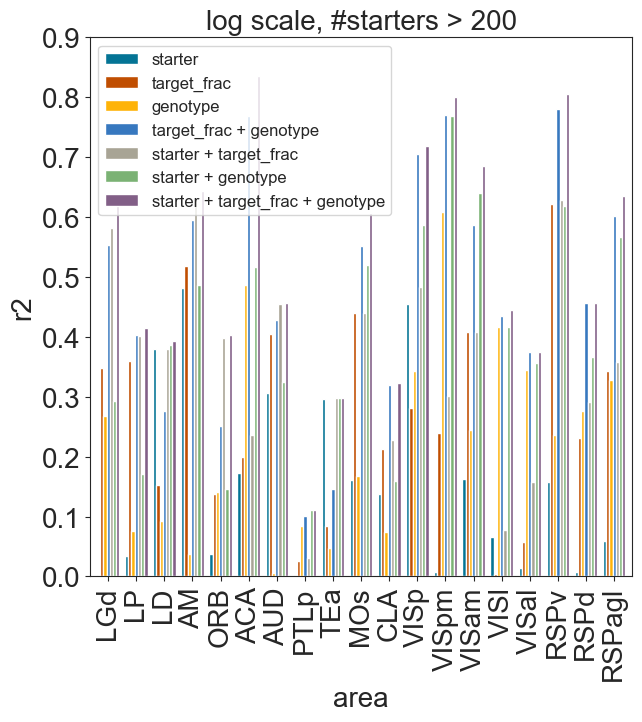

In [62]:
plotfn.plot_multivar(list_r2_log_200p_filt, 'log scale, #starters > 200', 'multivar_tip_log_starters200p', savepath_log_fig, 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


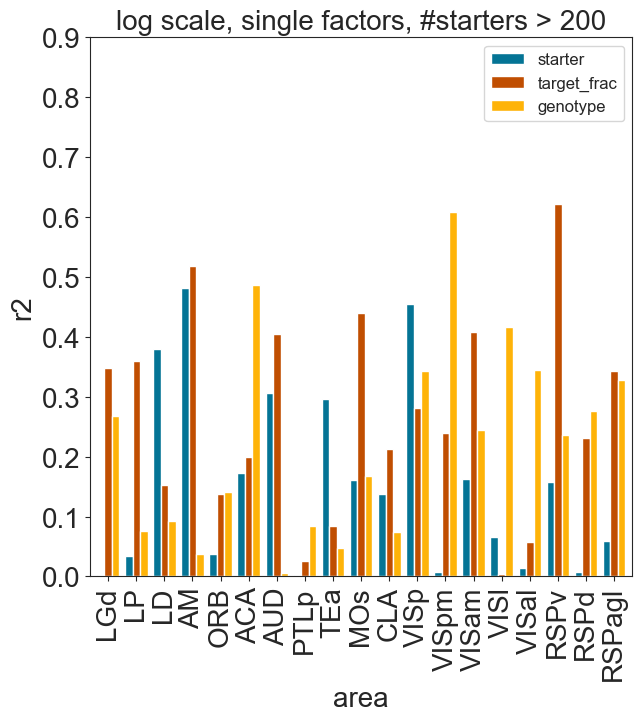

In [63]:
plotfn.plot_multivar(list_r2_log_200p_filt[['starter', 'target_frac', 'genotype']], 'log scale, single factors, #starters > 200', 'multivar_tip_single_factors_log_starters200p', savepath_log_fig, 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


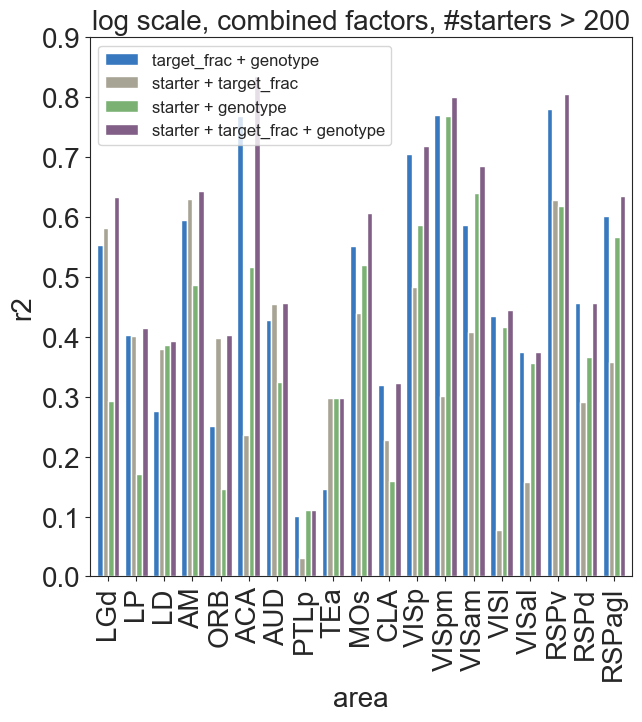

In [64]:
plotfn.plot_multivar(list_r2_log_200p_filt[['target_frac + genotype', 'starter + target_frac', 'starter + genotype', 'starter + target_frac + genotype']], 'log scale, combined factors, #starters > 200', 'multivar_tip_comb_factors_log_starters200p', savepath_log_fig, 2)

# **7. Save all data**

In [65]:
list_r2_lin_filt.to_hdf(os.path.join(savepath_lin_df, 'multireg_results_linear_allstarters.h5'), key = 'multireg_linear', mode = 'w')
list_r2_lin_200p_filt.to_hdf(os.path.join(savepath_lin_df, 'multireg_results_linear_starters200p.h5'), key = 'multireg_linear', mode = 'w')
list_r2_lin_200m_filt.to_hdf(os.path.join(savepath_lin_df, 'multireg_results_linear_starters200m.h5'), key = 'multireg_linear', mode = 'w')

list_r2_log_filt.to_hdf(os.path.join(savepath_log_df, 'multireg_results_linear_allstarters.h5'), key = 'multireg_linear', mode = 'w')
list_r2_log_200p_filt.to_hdf(os.path.join(savepath_log_df, 'multireg_results_linear_starters200p.h5'), key = 'multireg_linear', mode = 'w')
list_r2_log_200m_filt.to_hdf(os.path.join(savepath_log_df, 'multireg_results_linear_starters200m.h5'), key = 'multireg_linear', mode = 'w')

In [66]:
list_r2_lin_filt.to_csv(os.path.join(savepath_lin_csv, 'multireg_results_linear_allstarters.csv'))
list_r2_lin_200p_filt.to_csv(os.path.join(savepath_lin_csv, 'multireg_results_linear_starters200p.csv'))
list_r2_lin_200m_filt.to_csv(os.path.join(savepath_lin_csv, 'multireg_results_linear_starters200m.csv'))

list_r2_log_filt.to_csv(os.path.join(savepath_log_csv, 'multireg_results_linear_allstarters.csv'))
list_r2_log_200p_filt.to_csv(os.path.join(savepath_log_csv, 'multireg_results_linear_starters200p.csv'))
list_r2_log_200m_filt.to_csv(os.path.join(savepath_log_csv, 'multireg_results_linear_starters200m.csv'))